# Logistic Regression on the Swedish dataset
#### Using Logistic Regression for breast cancer subtype classification

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt

## Load and split the dataset

In [2]:
# Training set
X_train = pd.read_csv("data/swedish_train.csv")
X_train = X_train[X_train.expert_PAM50_subtypes != "Normal"]
y_train = X_train["expert_PAM50_subtypes"]

X_train.drop(['expert_PAM50_subtypes'], axis="columns", inplace=True)

# Final test set
X_test = pd.read_csv("data/swedish_test.csv")
X_test = X_test[X_test.expert_PAM50_subtypes != "Normal"]
y_test = X_test["expert_PAM50_subtypes"]

X_test.drop(['expert_PAM50_subtypes'], axis="columns", inplace=True)

# Order the features correctly

X_train = X_train.reindex(sorted(X_train.columns), axis="columns")
X_test = X_test.reindex(sorted(X_test.columns), axis="columns")

In [3]:
y_train.value_counts()

LumA     1450
LumB      667
Basal     317
Her2      314
Name: expert_PAM50_subtypes, dtype: int64

In [4]:
y_test.value_counts()

LumA     363
LumB     167
Basal     79
Her2      78
Name: expert_PAM50_subtypes, dtype: int64

### Scale the data

In [5]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Code to tune parameter C

In [6]:
values=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
i=1
results = pd.DataFrame(columns=["Index", "C", "Accuracy"])
mean_scores = []


skf = StratifiedKFold(n_splits=5)
for c in values:
    scores = []

    for train_index, test_index in skf.split(X_train_scaled, y_train):
        print("Fold {} of 5".format(i))
        X_cv_train, X_cv_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
        y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

        clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=c, multi_class="auto").fit(X_cv_train, y_cv_train)

        score = clf.score(X_cv_val, y_cv_val)
        results = results.append({'Fold': i, 'C' : c , 'Score' : score}, ignore_index=True)
        scores.append(score)
        i+=1

    i=1
    mean_scores.append(np.mean(scores))
    print('Results: {}'.format(scores))
    print('C: {}, Accuracy: {}'.format(c, np.mean(scores)))
        
results.to_csv("parameter_tuning/LogisticRegression/swedish_c_tuning_all_genes.csv", index=False)
mean_scores

Fold 1 of 5
Fold 2 of 5
Fold 3 of 5
Fold 4 of 5
Fold 5 of 5
Results: [0.1161524500907441, 0.1161524500907441, 0.11475409836065574, 0.11475409836065574, 0.11496350364963503]
C: 0.001, Accuracy: 0.11535532011048695
Fold 1 of 5
Fold 2 of 5
Fold 3 of 5
Fold 4 of 5
Fold 5 of 5
Results: [0.5898366606170599, 0.5843920145190563, 0.5828779599271403, 0.5828779599271403, 0.5875912408759124]
C: 0.01, Accuracy: 0.5855151671732618
Fold 1 of 5
Fold 2 of 5
Fold 3 of 5
Fold 4 of 5
Fold 5 of 5
Results: [0.9128856624319419, 0.9074410163339383, 0.907103825136612, 0.9162112932604736, 0.927007299270073]
C: 0.1, Accuracy: 0.9141298192866077
Fold 1 of 5
Fold 2 of 5
Fold 3 of 5
Fold 4 of 5
Fold 5 of 5
Results: [0.9165154264972777, 0.9165154264972777, 0.912568306010929, 0.9344262295081968, 0.9361313868613139]
C: 1, Accuracy: 0.9232313550749989
Fold 1 of 5
Fold 2 of 5
Fold 3 of 5
Fold 4 of 5
Fold 5 of 5
Results: [0.9165154264972777, 0.9183303085299456, 0.907103825136612, 0.9289617486338798, 0.916058394160584]
C:

[0.11535532011048695,
 0.5855151671732618,
 0.9141298192866077,
 0.9232313550749989,
 0.9173939405916599,
 0.9134032089338149,
 0.9035598163164587,
 0.8839101356261949]

### We can see that C=1 is the best parameter, hence why we'll use it to test our model

In [ ]:
clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=1, multi_class="auto").fit(X_train_scaled, y_train)

In [9]:
final_score = clf.score(X_test_scaled, y_test)
print('Confusion matrix\n', confusion_matrix(y_test, clf.predict(X_test_scaled)))
print('Accuracy', final_score)

Confusion matrix
 [[ 72   3   3   1]
 [  0  65   1  12]
 [  0   1 346  16]
 [  0   5  15 147]]
Accuracy 0.9170305676855895


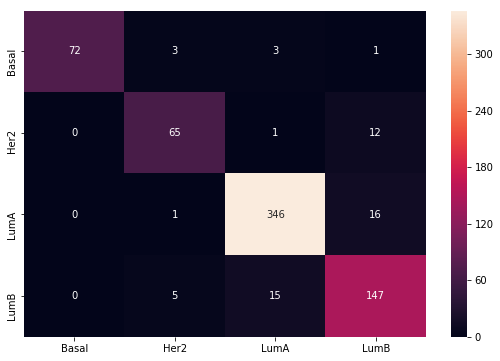

In [10]:
#How do I know the order of the labels???
import matplotlib.pyplot as plt
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test_scaled)), index = ["Basal", "Her2", "LumA", "LumB"], columns = ["Basal", "Her2", "LumA", "LumB"])
plt.figure(figsize=(9, 6))
sn.heatmap(conf_matrix, annot=True, fmt='g')
conf_matrix.to_csv("results/LogisticRegression/swedish_confusion_matrix_all_genes.csv")

# Let's try to use the 5k more "influential"

## With mutual_info_classif

In [12]:
selector = SelectKBest(mutual_info_classif, k=5000).fit(X_train_scaled, y_train)
relevant_idx = selector.get_support()
relevant_genes = X_train_scaled.columns[relevant_idx]

In [13]:
X_train_relevant = X_train_scaled[relevant_genes]
X_test_relevant = X_test_scaled[relevant_genes]

### Tune parameter C

In [14]:
values=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
i=1
results = pd.DataFrame(columns=["Index", "C", "Accuracy"])
mean_scores = []

skf = StratifiedKFold(n_splits=5)

for c in values:
    scores = []
    
    for train_index, test_index in skf.split(X_train_relevant, y_train):

        X_cv_train, X_cv_val = X_train_relevant.iloc[train_index], X_train_relevant.iloc[test_index]
        y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

        clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=c, multi_class="auto").fit(X_cv_train, y_cv_train)
        
        score = clf.score(X_cv_val, y_cv_val)
        results = results.append({'Fold': i, 'C' : c , 'Score' : score}, ignore_index=True)
        scores.append(score)
        i+=1
        
    i=1
    mean_scores.append(np.mean(scores))
    print('5-Fold results: {}'.format(scores))
    print('C: {}, Accuracy: {}'.format(c, np.mean(scores)))
        
results.to_csv("parameter_tuning/LogisticRegression/swedish_c_tuning_5k_mutual_info.csv", index=False)
mean_scores

5-Fold results: [0.1161524500907441, 0.1161524500907441, 0.11475409836065574, 0.11475409836065574, 0.11496350364963503]
C: 0.001, Accuracy: 0.11535532011048695
5-Fold results: [0.5843920145190563, 0.5825771324863884, 0.5883424408014571, 0.5865209471766849, 0.5875912408759124]
C: 0.01, Accuracy: 0.5858847551718998
5-Fold results: [0.9038112522686026, 0.9092558983666061, 0.9034608378870674, 0.9198542805100182, 0.9288321167883211]
C: 0.1, Accuracy: 0.9130428771641231
5-Fold results: [0.925589836660617, 0.9274047186932849, 0.9216757741347905, 0.9344262295081968, 0.9324817518248175]
C: 1, Accuracy: 0.9283156621643412
5-Fold results: [0.9237749546279492, 0.925589836660617, 0.9162112932604736, 0.9271402550091075, 0.927007299270073]
C: 10, Accuracy: 0.9239447277656442
5-Fold results: [0.9183303085299456, 0.9183303085299456, 0.9216757741347905, 0.9216757741347905, 0.9197080291970803]
C: 100, Accuracy: 0.9199440389053105
5-Fold results: [0.9165154264972777, 0.9165154264972777, 0.9089253187613844

[0.11535532011048695,
 0.5858847551718998,
 0.9130428771641231,
 0.9283156621643412,
 0.9239447277656442,
 0.9199440389053105,
 0.9141165743854905,
 0.9133906288113929]

### Train the Model (best c=1)

In [15]:
clf_5k_mutual = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=1, multi_class="auto").fit(X_train_relevant, y_train)

In [16]:
final_score = clf_5k_mutual.score(X_test_relevant, y_test)
print('Confusion matrix\n', confusion_matrix(y_test, clf_5k_mutual.predict(X_test_relevant)))
print('Accuracy', final_score)

Confusion matrix
 [[ 76   1   2   0]
 [  1  66   1  10]
 [  0   1 350  12]
 [  0   6  12 149]]
Accuracy 0.9330422125181951


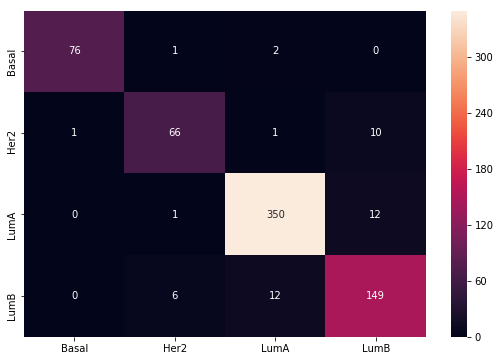

In [17]:
#How do I know the order of the labels???
import matplotlib.pyplot as plt
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf_5k_mutual.predict(X_test_relevant)), index = ["Basal", "Her2", "LumA", "LumB"], columns = ["Basal", "Her2", "LumA", "LumB"])
plt.figure(figsize=(9, 6))
sn.heatmap(conf_matrix, annot=True, fmt='g')
conf_matrix.to_csv("results/LogisticRegression/swedish_confusion_matrix_5k_mutual_info.csv")

## With chi2

In [18]:
selector = SelectKBest(chi2, k=5000).fit(X_train_scaled, y_train)
relevant_idx = selector.get_support()
relevant_genes = X_train_scaled.columns[relevant_idx]

/home/cristovao/miniconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


In [19]:
X_train_relevant = X_train_scaled[relevant_genes]
X_test_relevant = X_test_scaled[relevant_genes]

### Tune parameter C

In [20]:
values=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
i=1
results = pd.DataFrame(columns=["Index", "C", "Accuracy"])
mean_scores = []

skf = StratifiedKFold(n_splits=5)

for c in values:
    scores = []
    
    for train_index, test_index in skf.split(X_train_relevant, y_train):

        X_cv_train, X_cv_val = X_train_relevant.iloc[train_index], X_train_relevant.iloc[test_index]
        y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

        clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=c, multi_class="auto").fit(X_cv_train, y_cv_train)
        
        score = clf.score(X_cv_val, y_cv_val)
        results = results.append({'Fold': i, 'C' : c , 'Score' : score}, ignore_index=True)
        scores.append(score)
        i+=1
        
    i=1
    mean_scores.append(np.mean(scores))
    print('5-Fold results: {}'.format(scores))
    print('C: {}, Accuracy: {}'.format(c, np.mean(scores)))
        
results.to_csv("parameter_tuning/LogisticRegression/swedish_c_tuning_5k_chi2.csv", index=False)
mean_scores

5-Fold results: [0.1161524500907441, 0.1161524500907441, 0.11475409836065574, 0.11475409836065574, 0.11496350364963503]
C: 0.001, Accuracy: 0.11535532011048695
5-Fold results: [0.5825771324863884, 0.5807622504537205, 0.5846994535519126, 0.5828779599271403, 0.5875912408759124]
C: 0.01, Accuracy: 0.5837016074590149
5-Fold results: [0.9092558983666061, 0.9092558983666061, 0.9052823315118397, 0.9198542805100182, 0.927007299270073]
C: 0.1, Accuracy: 0.9141311416050286
5-Fold results: [0.9074410163339383, 0.9219600725952813, 0.907103825136612, 0.9344262295081968, 0.9416058394160584]
C: 1, Accuracy: 0.9225073965980173
5-Fold results: [0.9019963702359347, 0.9201451905626135, 0.9216757741347905, 0.9253187613843351, 0.9178832116788321]
C: 10, Accuracy: 0.9174038615993012
5-Fold results: [0.9147005444646098, 0.925589836660617, 0.9143897996357013, 0.9253187613843351, 0.9142335766423357]
C: 100, Accuracy: 0.9188465037575199
5-Fold results: [0.9183303085299456, 0.9183303085299456, 0.8961748633879781

[0.11535532011048695,
 0.5837016074590149,
 0.9141311416050286,
 0.9225073965980173,
 0.9174038615993012,
 0.9188465037575199,
 0.9093727280946793,
 0.9042884210053369]

### Train the model (best c=1)

In [21]:
clf_5k_chi2 = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=1, multi_class="auto").fit(X_train_relevant, y_train)

In [23]:
final_score = clf_5k_chi2.score(X_test_relevant, y_test)
print('Confusion matrix\n', confusion_matrix(y_test, clf_5k_chi2.predict(X_test_relevant)))
print('Accuracy', final_score)

Confusion matrix
 [[ 74   2   3   0]
 [  2  66   2   8]
 [  0   1 350  12]
 [  0   5  14 148]]
Accuracy 0.9286754002911208


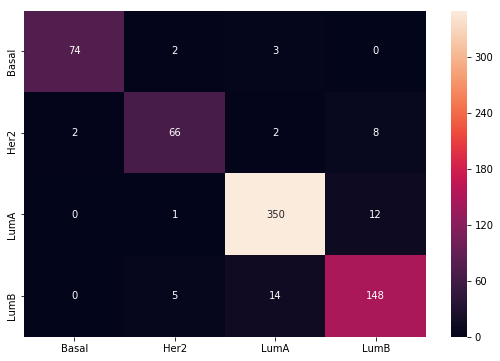

In [24]:
#How do I know the order of the labels???
import matplotlib.pyplot as plt
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf_5k_chi2.predict(X_test_relevant)), index = ["Basal", "Her2", "LumA", "LumB"], columns = ["Basal", "Her2", "LumA", "LumB"])
plt.figure(figsize=(9, 6))
sn.heatmap(conf_matrix, annot=True, fmt='g')
conf_matrix.to_csv("results/LogisticRegression/swedish_confusion_matrix_5k_chi2.csv")